In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns
from rich.console import Console
from sklearn.linear_model import LinearRegression

Training speed: 17,468 tokens/second
Training speed: 62,885,072 tokens/hour
Training speed: 1,509,241,737 tokens/day

Scaling law: Loss = 42.4825 * tokens^-0.1046
Tokens needed to reach loss=3: 101,912,654,144
Current tokens: 336,855,040

Remaining tokens: 101,575,799,104
ETA: 1615.3 hours (67.3 days)
Expected completion: 2026-04-20 13:16:27.728554067


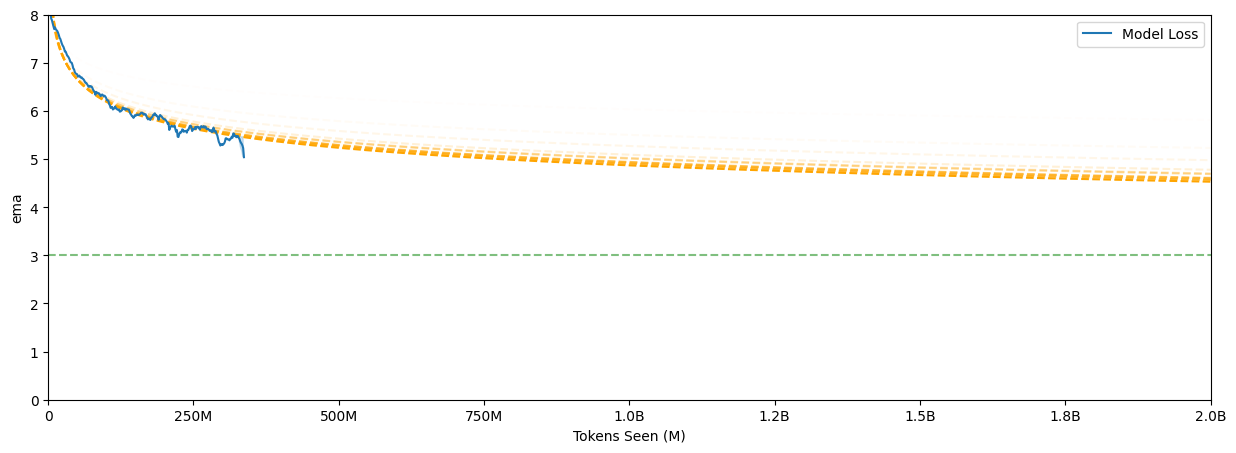

In [40]:
df = pd.read_json('models/flicker/training.jsonl', lines=True)

df["ema"] = df["loss"].ewm(span=20).mean()


x_label = 'tokens_seen'

fig, ax = plt.subplots(1, 1, figsize=(15, 5))

# end = 1.4e12
end = 2 * 1e9 # billions
tokens_seen = df[x_label].max()
for i in np.linspace(0.1, 1, 10):
    max_step = int(tokens_seen * i)
    reg_df = df[df[x_label] < max_step]
    if len(reg_df) < 10:
        continue

    X_log = np.log(reg_df[x_label].values).reshape(-1, 1)
    y_log = np.log(reg_df['ema'].values)

    model = LinearRegression()
    model.fit(X_log, y_log)

    # Extract power-law parameters
    b = model.coef_[0]  # exponent
    a = np.exp(model.intercept_)  # coefficient
    x_pred = np.linspace(0.1, end, 1000)  # Start at 0.1 instead of 0
    y_pred = a * np.power(x_pred, b)

    sns.lineplot(x=x_pred, y=y_pred, linestyle='--', color='orange', alpha=i ** 2)

g = sns.lineplot(df, x=x_label, y='ema', label="Model Loss")
g.axhline(3, color='green', linestyle='--', alpha=0.5)

# if the x label is 'tokens_seen', format the x scale to be in millions
g.set_xlabel('Tokens Seen (M)')

def smart_formatter(x, pos):
    if x >= 1e12:
        return f'{x/1e12:.1f}T'
    if x >= 1e9:
        return f'{x/1e9:.1f}B'
    if x >= 1e6:
        return f'{x/1e6:.0f}M'
    if x >= 1e3:
        return f'{x/1e3:.1f}K'
    return f'{x:.0f}'

g.xaxis.set_major_formatter(ticker.FuncFormatter(smart_formatter))

g.set_ylim(0, 8)
g.set_xlim(0, end)


# ---------------------------

# filter df where 'datetime' is not null
df = df[df['datetime'].notnull()]

# Convert datetime to actual datetime objects if they're strings
df['datetime'] = pd.to_datetime(df['datetime'])

# Calculate tokens per second based on the time progression
df['elapsed_seconds'] = (df['datetime'] - df['datetime'].min()).dt.total_seconds()
tokens_per_second = df[x_label].iloc[-1] / df['elapsed_seconds'].iloc[-1]

print(f"Training speed: {tokens_per_second:,.0f} tokens/second")
print(f"Training speed: {tokens_per_second * 3600:,.0f} tokens/hour")
print(f"Training speed: {tokens_per_second * 3600 * 24:,.0f} tokens/day")

# Use the best-fit scaling law (using full data) to predict tokens needed for loss=3
X_log = np.log(df[x_label].values).reshape(-1, 1)
y_log = np.log(df['ema'].values)
model = LinearRegression()
model.fit(X_log, y_log)

b = model.coef_[0]
a = np.exp(model.intercept_)

target_loss = 3
tokens_needed = np.power(target_loss / a, 1 / b)

print(f"\nScaling law: Loss = {a:.4f} * tokens^{b:.4f}")
print(f"Tokens needed to reach loss={target_loss}: {tokens_needed:,.0f}")
print(f"Current tokens: {df[x_label].iloc[-1]:,.0f}")

if tokens_needed > df[x_label].iloc[-1]:
    remaining_tokens = tokens_needed - df[x_label].iloc[-1]
    remaining_seconds = remaining_tokens / tokens_per_second
    remaining_hours = remaining_seconds / 3600
    remaining_days = remaining_hours / 24
    
    eta = df['datetime'].iloc[-1] + pd.Timedelta(seconds=remaining_seconds)
    
    print(f"\nRemaining tokens: {remaining_tokens:,.0f}")
    print(f"ETA: {remaining_hours:.1f} hours ({remaining_days:.1f} days)")
    print(f"Expected completion: {eta}")
else:
    print(f"\nTarget loss already achieved!")